In [1]:
# install dependencies (only once)
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
# load .env and configure openai
import os
import openai
from dotenv import load_dotenv

load_dotenv()

os.environ["LITELLM_LOGGING"] = "false"

api_key = os.getenv("OPENAI_API_KEY")
qdrant_url = os.getenv("QDRANT_URL")

assert api_key, "OPENAI_API_KEY is missing in .env"
assert qdrant_url, "QDRANT_URL is missing in .env"

openai.api_key = api_key

---

## ✅ Task 1 – PDF Scraping (Cardiology Guidelines)

**Goal:**  
Download medical documents (PDF) from the Ministry of Health of Ukraine website, from the **Cardiology** section.

**Task Context:**  
The website uses **Cloudflare** protection, which blocks simple HTTP requests. Also, some documents are opened through JavaScript, not direct links.

**Problems and Solutions:**
- ❌ `requests` and similar libraries were blocked → ✅ Used **undetected_chromedriver** to simulate a real browser.
- ❌ PDF downloads needed extra browser permissions → ✅ Used Chrome DevTools Protocol to allow direct downloads.
- ✅ Found the correct section in the HTML using its ID, and used **BeautifulSoup** to get all the document links.

**Result:**  
> Downloaded all PDF documents from the cardiology section, with saved metadata: title, link, and local file path.


In [9]:
import re
import undetected_chromedriver as uc
from bs4 import BeautifulSoup
from tqdm import tqdm
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium_stealth import stealth

In [3]:
# create a folder for PDFs
download_dir = os.path.abspath("downloads")
os.makedirs(download_dir, exist_ok=True)

In [4]:
# chrome options
options = uc.ChromeOptions()
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features=AutomationControlled")

# chrome prefs
prefs = {
    "download.default_directory": download_dir,
    "download.prompt_for_download": False,
    "plugins.always_open_pdf_externally": True,
    "profile.default_content_settings.popups": 0,
}
options.add_experimental_option("prefs", prefs)

driver = uc.Chrome(options=options, headless=False)

stealth(driver,
    languages=["en-US", "en"],
    vendor="Google Inc.",
    platform="MacIntel",
    webgl_vendor="Intel Inc.",
    renderer="Intel Iris OpenGL Engine",
    fix_hairline=True,
)

# set automatical files download using DevTools Protocol
driver.execute_cdp_cmd("Page.setDownloadBehavior", {
    "behavior": "allow",
    "downloadPath": download_dir
})

{}

In [6]:
url = "https://guidelines.moz.gov.ua/documents"
driver.get(url)
# wait for the page to load completely
try:
    WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, "accordion"))
    )
except:
    print("Pass cloudfare and start this block again")
# get html to parse it with bs4
html = driver.page_source

In [7]:
# get the page source and parse it
soup = BeautifulSoup(html, 'html.parser')

# find the cardiology section by its ID
cardiology_section = soup.find('div', id='collapse11')

documents = cardiology_section.find_all('a', href=True)

# download All PDFs
for link in tqdm(documents):
    # visit each document's URL to trigger the download
    driver.get(f"https://guidelines.moz.gov.ua{link['href']}")
    # wait for the page to load (important for triggering the PDF download)
    WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "body"))
        )
driver.close()

100%|███████████████████████████████████████████| 75/75 [05:27<00:00,  4.37s/it]


After all files are loaded we can start to prepare our pdfs to loading to the knowleadge base

In [11]:
# get all PDFs from the folder and create list with paths and urls
pdf_files = [f for f in os.listdir(download_dir) if f.endswith('.pdf')]

pdf_list = []
for pdf in pdf_files:
    # skip duplicates
    if re.search(r'\(\d+\)\.pdf$', pdf):
        continue
    document_name = pdf.replace('.pdf', '')
    pdf_path = os.path.join(download_dir, pdf)
    url = f"https://guidelines.moz.gov.ua/documents/{document_name}"
    pdf_list.append({"pdf_path": pdf_path, "url": url})


3890 (1).pdf
3890 (2).pdf
3890 (3).pdf


In [12]:
pdf_list[:3]

[{'pdf_path': '/Users/dark/Desktop/InvolveTestTask/downloads/3357.pdf',
  'url': 'https://guidelines.moz.gov.ua/documents/3357'},
 {'pdf_path': '/Users/dark/Desktop/InvolveTestTask/downloads/3008.pdf',
  'url': 'https://guidelines.moz.gov.ua/documents/3008'},
 {'pdf_path': '/Users/dark/Desktop/InvolveTestTask/downloads/3222.pdf',
  'url': 'https://guidelines.moz.gov.ua/documents/3222'}]

---

## ✅ Task 2 – Vector Indexing (Medical Guidelines)

**Goal:**  
Build a vector index that helps find relevant parts of medical documents for user questions.

**Task Context:**  
After downloading the PDFs, the next step was to turn them into small parts ("chunks"), create embeddings, and store them in **Qdrant** for fast search.

**Problems and Solutions:**
- ❌ Tried chunking by table of contents and plain text → ❌ Results were not relevant  
  → ✅ **Page-based chunking** worked best and gave better answers.
- ❌ Embedding generation was slow → ✅ Used **batch requests** to OpenAI API.
- ✅ Each chunk includes metadata (title, page, URL), which helps in source linking later.

**Result:**  
> A fast and accurate vector index with good page-level context and source info.


In [13]:
import re
import fitz
import hashlib
from tqdm import tqdm
from pathlib import Path
from qdrant_client import QdrantClient
from qdrant_retriever import QdrantRetriever
from qdrant_client.http.models import PointStruct, VectorParams, Distance

In [14]:
# function for batching requests for embedding
def get_openai_embeddings_batch(chunks: list[str], model: str = "text-embedding-3-small") -> list[list[float]]:
    if not chunks:
        return []
    response = openai.embeddings.create(input=chunks, model=model)
    sorted_data = sorted(response.data, key=lambda x: x.index)
    return [d.embedding for d in sorted_data]

In [15]:
# function for chanking by page
def chunk_text_by_pages_with_overlap(pages: list[str], window_size: int = 2, overlap: int = 1) -> list[tuple[str, str]]:
    chunks = []
    i = 0
    while i < len(pages):
        end = min(i + window_size, len(pages))
        chunk_text = "\n".join(pages[i:end])
        chunk_name = f"pages_{i+1}_{end}"
        chunks.append((chunk_name, chunk_text))
        if end == len(pages):
            break
        i += window_size - overlap
    return chunks

In [16]:
# recreate collection
collection_name = "medical_guidelines_openai"

client = QdrantClient(host="localhost", port=6333)
if client.collection_exists(collection_name):
    client.delete_collection(collection_name)
    
if collection_name not in [c.name for c in client.get_collections().collections]:
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=1536, distance=Distance.COSINE)
    )

In [17]:
# loop for processing PDF files
for pdf in tqdm(pdf_list, desc="Chanking by page", unit="chunk"):
    pdf_path = pdf["pdf_path"]
    path_obj = Path(pdf_path)

    # reading PDF
    with fitz.open(pdf_path) as pdf_obj:
        pages = [page.get_text() for page in pdf_obj]

    # extracting metadata
    text = "\n".join(pages)
    title_match = re.search(r"Настанова\s+\d+\.*.*", text)
    title = title_match.group(0).strip() if title_match else metadata.get("title", "Unnamed")
    doc_id_match = re.search(r"ebm\d{5}", text)
    doc_id = doc_id_match.group(0) if doc_id_match else "unknown"
    doc_url = pdf["url"]

    # chunking by pages with overlap
    page_chunks = chunk_text_by_pages_with_overlap(pages, window_size=2, overlap=1)

    # creating chunk metadata
    chunk_data = []
    for i, (chunk_name, chunk_text) in enumerate(page_chunks):
        uid = int(hashlib.md5((doc_id + chunk_name).encode()).hexdigest(), 16) % (10 ** 12)
        chunk_data.append({
            "uid": uid,
            "chunk": chunk_text,
            "section": chunk_name,
            "index": i
        })

    # getting embeddings in batch
    chunks = [item["chunk"] for item in chunk_data]
    vectors = get_openai_embeddings_batch(chunks)

    # creating PointStruct
    points = []
    for data, vector in zip(chunk_data, vectors):
        points.append(PointStruct(
            id=data["uid"],
            vector=vector,
            payload={
                "text": data["chunk"],
                "section": data["section"],
                "title": title,
                "doc_id": doc_id,
                "doc_url": doc_url,
                "source_file": path_obj.name,
                "chunk_index": data["index"],
            }
        ))

    # uploading to qdrant
    client.upsert(collection_name=collection_name, points=points)

Chanking by page: 100%|████████████████████████████████████████████████████████████████████| 75/75 [01:52<00:00,  1.50s/chunk]


In [18]:
# show results of vector search using qdrant
query = "Чим відрізняється нестабільна стенокардія від стабільної?"

query_vector = get_openai_embeddings_batch([query])[0]

search_results = client.search(
    collection_name=collection_name,
    query_vector=query_vector,
    limit=1
)

for i, result in enumerate(search_results, 1):
    print(f"\n🔹 Результат #{i}")
    print(f"📖 Документ: {result.payload.get('title')}")
    print(f" URL: {result.payload.get('doc_url')}")
    print(f"🔗 Файл: {result.payload.get('source_file')}")
    print(f"\n{result.payload['text'][:200]}...")



🔹 Результат #1
📖 Документ: Настанова 00080. Ішемічна хвороба серця
 URL: https://guidelines.moz.gov.ua/documents/2992
🔗 Файл: 2992.pdf

1. починається поступово при навантаженні, якщо
навантаження є раптовим — швидше посилюється, якщо
навантаження триває. Іноді тривале навантаження не
збільшує біль, а приносить полегшення (феномен
сте...


/var/folders/00/84z14p7j3qg0kd12jv5bb8v80000gp/T/ipykernel_93034/3006316761.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


---

## ✅ Task 3 – RAG Agent (with DSPy)

**🎯 Goal:**  
Create an agent that can answer questions using the most relevant parts of medical documents.

**📚 Task Context:**  
The agent is built using **DSPy** and uses the vector index created in **Task 2**.  
The answer should be based on facts and must include the **original document source** and, if possible, the **page number**.

> 🧠 The agent logic is implemented in the [`cardiology_agent.py`](./cardiology_agent.py) file.  
> This notebook block demonstrates **how the agent is used** in practice within the full RAG pipeline.

> 🧲 To support context retrieval, I implemented a custom retriever in [`qdrant_retriever.py`](./qdrant_retriever.py).  
> It performs vector similarity search in **Qdrant** and returns the most relevant document chunks with metadata for citation.

**🛠️ Problems & Solutions:**
- ❌ At first, the agent did **not include the source** → ✅ Solved by changing the **prompt** to ask the model to always mention the document.
- ❌ The answer **did not include page numbers** → ✅ Updated the code to **add page numbers to metadata**, so the agent can mention them when available.
- ✅ Added links to the document so users can check the source.
- ✅ Implemented a dedicated retriever class to interface with Qdrant and ensure accurate context retrieval.

**📈 Result:**  
> A working RAG agent that gives clear, source-grounded answers and shows the document (and often the page) where the information was found.


In [19]:
from qdrant_retriever import QdrantRetriever
from cardiology_agent import CardiologyRAGAgent
from IPython.display import Markdown, display

In [20]:
# preparing queries
relevant_queries = [
    "Які є класи антигіпертензивних препаратів та в чому різниця?",
    "Як діагностується тахікардія у дорослих?",
    "Які є клінічні ознаки гострої серцевої недостатності?",
    "Чи дозволена фізична активність пацієнтам із хронічною ІХС?",
    "Як проводиться добове моніторування артеріального тиску?",
    "Які цільові значення артеріального тиску для літніх пацієнтів?",
    "Що таке вторинна профілактика серцево-судинних захворювань?",
]

irrelevant_queries = [
    "Які вітаміни краще приймати восени для імунітету?",
    "Як лікувати псоріаз у дітей?",
    "Чи корисне вживання зеленого чаю для печінки?",
    "Що рекомендує МОЗ щодо вакцинації від COVID-19 у 2025 році?",
    "Які є вправи для покращення постави у школярів?",
    "Чи дозволена сауна під час вагітності?",
]

In [21]:
# init retriever
retriever = QdrantRetriever(
    collection_name="medical_guidelines_openai", 
    qdrant_url=qdrant_url
)

# init agent
agent = CardiologyRAGAgent(
    llm_model='openai/gpt-4o-mini', 
    llm_model_kwargs={"api_key": api_key}, 
    retriever=retriever)

In [22]:
# function for beautiful output
def show_query_output(query, output):
    display(Markdown(f"""
### 🔹 **Input**
{query}

### 🔸 **Output**
{output}
---
"""))

In [23]:
# results with relevant queries
for query in relevant_queries:
    result = agent.invoke(query)
    show_query_output(query, result.output)


### 🔹 **Input**
Які є класи антигіпертензивних препаратів та в чому різниця?

### 🔸 **Output**
Антигіпертензивні препарати поділяються на кілька класів: 

1. **Інгібітори АПФ** (наприклад, еналаприл) - знижують артеріальний тиск, блокуючи ангіотензин.
2. **Блокатори рецепторів ангіотензину II** (блокатори РА) - діють подібно до інгібіторів АПФ.
3. **Бета-блокатори** (наприклад, метопролол) - знижують частоту серцевих скорочень.
4. **Блокатори кальцієвих каналів** (наприклад, амлодипін) - розширюють судини.
5. **Діуретики** (наприклад, гідрохлортіазид) - виводять надлишок рідини.

Кожен клас має свої механізми дії та показання до застосування.

Джерела:
1. Настанова 00072. Медикаментозне лікування артеріальної гіпертензії, сторінка 2-3. [Link](https://guidelines.moz.gov.ua/documents/2989)
---



### 🔹 **Input**
Як діагностується тахікардія у дорослих?

### 🔸 **Output**
Діагностика тахікардії у дорослих базується на анамнезі, клінічному обстеженні та ЕКГ, знятій під час нападу аритмії. Важливими є зміни на ЕКГ, такі як форма комплексів QRS, тривалість інтервалу QT та інші. Лабораторні дослідження, включаючи аналіз крові та електроліти, також є необхідними. У разі підозри на серцево-судинні захворювання пацієнта направляють до кардіолога для подальшого обстеження. 

Джерела:
1. Настанова 00065. Шлуночкова тахікардія, сторінки 3-6. [Link](https://guidelines.moz.gov.ua/documents/2986)
---



### 🔹 **Input**
Які є клінічні ознаки гострої серцевої недостатності?

### 🔸 **Output**
Клінічні ознаки гострої серцевої недостатності включають: ознаки застою кровообігу (сухі та вологі хрипи, підвищений тиск у яремних венах, набряки, гепатомегалія) та ознаки органної гіпоперфузії (порушення свідомості, млявість, запаморочення, холодні кінцівки, ціаноз, зниження діурезу). Всі ці симптоми вимагають негайного лікування. 

Джерела:
1. Настанова 00089. Гостра серцева недостатність і набряк легень, стор. 2. [Link](https://guidelines.moz.gov.ua/documents/2997)
---



### 🔹 **Input**
Чи дозволена фізична активність пацієнтам із хронічною ІХС?

### 🔸 **Output**
Фізична активність пацієнтам із хронічною ішемічною хворобою серця (ІХС) дозволена, але з певними умовами. Перед призначенням проби з фізичним навантаженням лікар повинен оцінити ймовірність розвитку ІХС. Пробу можна проводити, якщо пацієнт стабільний, не має нападів болю в грудях, і його гемодинамічний статус нормальний. Важливо уникати раптової та надмірної фізичної активності. 

Джерела:
1. Настанова 00985. Проби з дозованим фізичним навантаженням, сторінки 2-3. [Link](https://guidelines.moz.gov.ua/documents/3713)
2. Настанова 00080. Ішемічна хвороба серця, сторінки 9-10. [Link](https://guidelines.moz.gov.ua/documents/2992)
---



### 🔹 **Input**
Як проводиться добове моніторування артеріального тиску?

### 🔸 **Output**
Добове моніторування артеріального тиску проводиться для виявлення резистентності до лікування, епізодів гіпотензії, нічного підвищення тиску або значної невідповідності між домашніми та лікарняними вимірюваннями. Вимірювання здійснюється автоматичним апаратом на не-домінуючій руці, з фіксацією середнього значення вимірювань зранку та ввечері протягом 4-7 днів. Рекомендується проводити 1 вимірювання зранку та ввечері. 

Джерела:
1. Настанова 00069. Гіпертензія: обстеження та стартове лікування, сторінки 2-3. [Link](https://guidelines.moz.gov.ua/documents/2988)
---



### 🔹 **Input**
Які цільові значення артеріального тиску для літніх пацієнтів?

### 🔸 **Output**
Цільовим рівнем артеріального тиску для літніх пацієнтів є <150/90 мм рт. ст. (при домашньому вимірюванні - <140/85 мм рт. ст.). У пацієнтів з діабетом або хворобами нирок цільовий рівень є нижчим. Важливо контролювати артеріальний тиск, оскільки підвищення АТ пов'язане з підвищеною кардіоваскулярною захворюваністю та смертністю.

Джерела:
1. Настанова 00069. Гіпертензія: обстеження та стартове лікування, стор. 2-3. [Link](https://guidelines.moz.gov.ua/documents/2988)
---



### 🔹 **Input**
Що таке вторинна профілактика серцево-судинних захворювань?

### 🔸 **Output**
Вторинна профілактика серцево-судинних захворювань передбачає ефективне лікування дисліпідемії у пацієнтів з ішемічною хворобою серця або атеросклеротичними захворюваннями, а також у хворих на діабет. Важливо визначати та лікувати пацієнтів із сімейною гіперхолестеринемією. Лікування гіперліпідемії, зокрема статинами, доведено знижує смертність та ускладнення ішемічної хвороби серця. 

Джерела:
1. Настанова 00523. Стратегії та пріоритети скринінгу на дисліпідемію, сторінка 1. [Link](https://guidelines.moz.gov.ua/documents/3358)
---


In [24]:
# results with irrelevant queries
for query in irrelevant_queries:
    result = agent.invoke(query)
    show_query_output(query, result.output)


### 🔹 **Input**
Які вітаміни краще приймати восени для імунітету?

### 🔸 **Output**
Не знайдено інформації про вітаміни для імунітету восени у документах розділу 'Кардіологія' Міністерства охорони здоров’я України.
---



### 🔹 **Input**
Як лікувати псоріаз у дітей?

### 🔸 **Output**
Не знайдено інформації про лікування псоріазу у дітей у документах розділу 'Кардіологія' Міністерства охорони здоров’я України.
---



### 🔹 **Input**
Чи корисне вживання зеленого чаю для печінки?

### 🔸 **Output**
Не знайдено інформації про вживання зеленого чаю для печінки у документах розділу 'Кардіологія' Міністерства охорони здоров’я України.
---



### 🔹 **Input**
Що рекомендує МОЗ щодо вакцинації від COVID-19 у 2025 році?

### 🔸 **Output**
Не знайдено інформації про вакцинацію від COVID-19 у документах розділу 'Кардіологія' Міністерства охорони здоров’я України.
---



### 🔹 **Input**
Які є вправи для покращення постави у школярів?

### 🔸 **Output**
Не знайдено інформації про вправи для покращення постави у школярів у документах розділу 'Кардіологія' Міністерства охорони здоров’я України.
---



### 🔹 **Input**
Чи дозволена сауна під час вагітності?

### 🔸 **Output**
Не знайдено інформації про сауну під час вагітності у документах розділу 'Кардіологія' Міністерства охорони здоров’я України.
---


---

## ✅ Task 4: Answer Evaluation (DeepEval)

**🎯 Goal:**  
Automatically check the quality of the agent’s answers using advanced evaluation metrics.

**📚 Task Context:**  
Manual checking takes too much time. To solve this, I used **DeepEval** to run tests on a list of medical questions with correct answers based on official cardiology guidelines from the Ministry of Health of Ukraine.

> 🧪 To simplify running and managing evaluation, I created a dedicated utility class in [`metric_collector.py`](./metric_collector.py).  
> It provides a convenient interface for loading test cases, executing metrics, and visualizing results.

**🛠️ Problems & Solutions:**
- ❌ At first, it was hard to create the "correct" answers → ✅ I used real text from the documents as the expected answer.
- ✅ To better understand the results, I visualized all metrics using `VisualMetricCollector`.

**📊 Metrics Used:**
- `ContextualPrecisionMetric` – Checks how much of the retrieved info was used correctly.
- `ContextualRecallMetric` – Checks how much of the correct info was retrieved.
- `ContextualRelevancyMetric` – Checks if the retrieved info is related to the question.
- `AnswerRelevancyMetric` – Evaluates if the answer is relevant and explains the reason.
- `FaithfulnessMetric` – Measures how true and correct the answer is, with explanation.
- `GEval` for **Source Attachment** – A custom evaluation to check:
  - if the source is correct, specific (e.g., includes section or page),
  - if the link contradicts or misses the claim → strong penalty.

**📈 Result:**  
> A complete automated system that tests answer quality with multiple detailed metrics and gives visual feedback for improvement.


In [25]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams
from metric_collector import VisualMetricCollector

from deepeval.metrics import (
    ContextualPrecisionMetric,
    ContextualRecallMetric,
    ContextualRelevancyMetric,
    AnswerRelevancyMetric,
    FaithfulnessMetric
)

from qdrant_retriever import QdrantRetriever
from cardiology_agent import CardiologyRAGAgent

In [26]:
# preparing queries and expected answers
relevant_queries = [
    "Які є класи антигіпертензивних препаратів та в чому різниця?",
    "Як діагностується тахікардія у дорослих?",
    "Які є клінічні ознаки гострої серцевої недостатності?",
    "Чи дозволена фізична активність пацієнтам із хронічною ІХС?",
    "Як проводиться добове моніторування артеріального тиску?",
    "Які цільові значення артеріального тиску для літніх пацієнтів?",
    "Що таке вторинна профілактика серцево-судинних захворювань?",
]

irrelevant_queries = [
    "Які вітаміни краще приймати восени для імунітету?",
    "Як лікувати псоріаз у дітей?",
    "Чи корисне вживання зеленого чаю для печінки?",
    "Які є вправи для покращення постави у школярів?",
    "Чи дозволена сауна під час вагітності?"
]

expected_answers = [
    "Основні класи антигіпертензивних препаратів включають: інгібітори АПФ, блокатори рецепторів ангіотензину, бета-блокатори, блокатори кальцієвих каналів та діуретики. Вони відрізняються механізмами дії та показаннями до застосування, що впливає на вибір лікування.\n\nДжерела:\n1. Настанова 00072. Медикаментозне лікування артеріальної гіпертензії, сторінки 2–3. [Link](https://guidelines.moz.gov.ua/documents/2989)\n2. Настанова 00072. Медикаментозне лікування артеріальної гіпертензії, сторінки 14–15. [Link](https://guidelines.moz.gov.ua/documents/2989)",
    "Тахікардія у дорослих діагностується на основі анамнезу, клінічного обстеження та ЕКГ, знятої під час нападу. Важливо правильно диференціювати шлуночкову тахікардію від надшлуночкової, що може бути небезпечним.\n\nДжерела:\n1. Настанова 00065. Шлуночкова тахікардія, сторінки 2–6. [Link](https://guidelines.moz.gov.ua/documents/2986)",
    "Клінічні ознаки гострої серцевої недостатності включають: сухі та вологі хрипи, підвищений тиск у яремних венах, набряки, порушення свідомості, холодні кінцівки, ціаноз. Ці симптоми потребують термінового лікування.\n\nДжерела:\n1. Настанова 00089. Гостра серцева недостатність і набряк легень, сторінки 3–4. [Link](https://guidelines.moz.gov.ua/documents/2997)",
    "Фізична активність пацієнтам із хронічною ІХС дозволена за умови стабільного стану та відсутності нападів болю в грудях. Лікар має оцінити ймовірність розвитку ІХС перед призначенням фізичного навантаження.\n\nДжерела:\n1. Настанова 00985. Проби з дозованим фізичним навантаженням, сторінки 2–3. [Link](https://guidelines.moz.gov.ua/documents/3713)\n2. Настанова 00080. Ішемічна хвороба серця, сторінки 9–10. [Link](https://guidelines.moz.gov.ua/documents/2992)",
    "Добове моніторування артеріального тиску проводиться для виявлення резистентності до лікування, епізодів гіпотензії, нічного підвищення тиску або значної невідповідності між домашніми та лікарняними вимірюваннями.\n\nДжерела:\n1. Настанова 00069. Гіпертензія: обстеження та стартове лікування, сторінки 2–3. [Link](https://guidelines.moz.gov.ua/documents/2988)",
    "Цільові значення артеріального тиску для літніх пацієнтів становлять <150/90 мм рт. ст. (в лікарні) та <140/85 мм рт. ст. (вдома). Для пацієнтів з діабетом або хворобами нирок ці значення можуть бути нижчими.\n\nДжерела:\n1. Настанова 00069. Гіпертензія: обстеження та стартове лікування, сторінки 2–3. [Link](https://guidelines.moz.gov.ua/documents/2988)",
    "Вторинна профілактика серцево-судинних захворювань полягає в ефективному лікуванні дисліпідемії у пацієнтів з ішемічною хворобою серця та іншими атеросклеротичними захворюваннями. Вона також включає визначення та лікування пацієнтів із сімейною гіперхолестеринемією.\n\nДжерела:\n1. Настанова 00523. Стратегії та пріоритети скринінгу на дисліпідемію, сторінка 1. [Link](https://guidelines.moz.gov.ua/documents/3358)"
]


In [27]:
# init retriever
retriever = QdrantRetriever(
    collection_name="medical_guidelines_openai", 
    qdrant_url=qdrant_url
)

# init agent
agent = CardiologyRAGAgent(
    llm_model='openai/gpt-4o-mini', 
    llm_model_kwargs={"api_key": api_key}, 
    retriever=retriever)

In [28]:
# init metrics
contextual_precision = ContextualPrecisionMetric(model="gpt-4o-mini")
contextual_recall = ContextualRecallMetric(model="gpt-4o-mini")
contextual_relevancy = ContextualRelevancyMetric(model="gpt-4o-mini")
answer_relevancy = AnswerRelevancyMetric(model="gpt-4o-mini", include_reason=True)
faithfulness_metric = FaithfulnessMetric(model="gpt-4o-mini", include_reason=True)
source_attachment_metric = GEval(
    name="Source Attachment",
    criteria="Evaluate whether the sources attached by the agent are correct, specific, and relevant to the provided answer.",
    evaluation_steps=[
        "Check whether the linked source matches the content used in the answer.",
        "Heavily penalize if the source contradicts or does not contain the stated information.",
        "Reward if the source is specific (e.g., includes section or page number) and directly supports the claims.",
        "Neutral or minor penalty for formatting issues unless they affect usability of the link."
    ],
    model="gpt-4o-mini",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.RETRIEVAL_CONTEXT]
)

In [29]:
# init collector for evaluating with metrics
collector = VisualMetricCollector(
    metrics=[
        source_attachment_metric, 
        faithfulness_metric, 
        answer_relevancy, 
        contextual_precision, 
        contextual_recall
    ], 
    retriever=retriever, 
    agent=agent)

Creating test cases: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.68s/it]


✨ You're running DeepEval's latest Source Attachment (GEval) Metric! (using gpt-4o-mini, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o-mini, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o-mini, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Precision Metric! (using gpt-4o-mini, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Contextual Recall Metric! (using gpt-4o-mini, strict=False, async_mode=True)...

Evaluating 7 test case(s) in parallel: |█████████████████████████████████████|100% (7/7) [Time Taken: 00:37,  5.37s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.



Overall Metric Pass Rates

Source Attachment (GEval): 100.00% pass rate
Faithfulness: 100.00% pass rate
Answer Relevancy: 100.00% pass rate
Contextual Precision: 100.00% pass rate
Contextual Recall: 100.00% pass rate




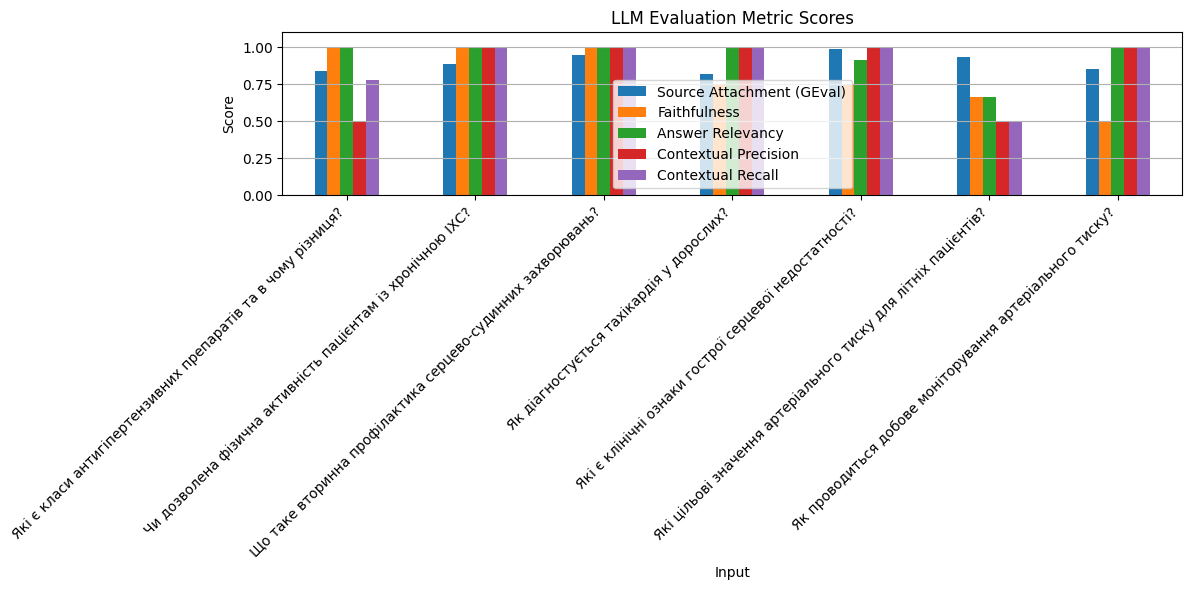

In [30]:
# creating test-cases using queries and expected answers
test_cases = collector.collect_test_cases(relevant_queries, expected_answers)
# evaluating
scores = collector.collect_metric_results()
# visualizing 
collector.visualize()

In [31]:
# change metrics for evaluating irrelevant queries
collector.metrics = [
    faithfulness_metric
] 

Creating test cases: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o-mini, strict=False, async_mode=True)...

Evaluating 5 test case(s) in parallel: |█████████████████████████████████████|100% (5/5) [Time Taken: 00:31,  6.27s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.



Overall Metric Pass Rates

Faithfulness: 100.00% pass rate




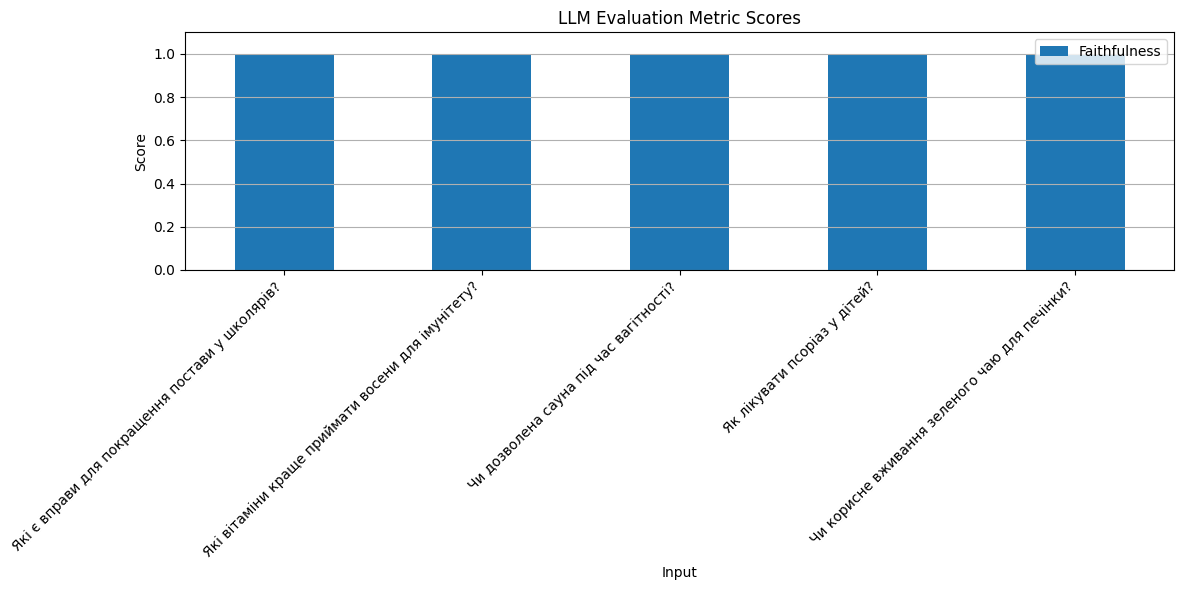

In [32]:
# creating test-cases using irrelevant queries
test_cases = collector.collect_test_cases(irrelevant_queries)
# evaluating
scores = collector.collect_metric_results()
# visualizing 
collector.visualize()